In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [2]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/codes.txt')]

In [0]:
path_lbl = path/'labels'
path_images = path/'images'

In [4]:
fnames = get_image_files(path_images)
fnames[:5]

[PosixPath('/root/.fastai/data/camvid/images/0016E5_05490.png'),
 PosixPath('/root/.fastai/data/camvid/images/0001TP_006780.png'),
 PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f00960.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_07989.png'),
 PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f03000.png')]

In [5]:
lbl_names = get_image_files(path_lbl)
lbl_names[:5]

[PosixPath('/root/.fastai/data/camvid/labels/0006R0_f01260_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f03150_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f02220_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_02040_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_08063_P.png')]

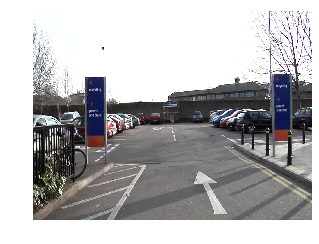

In [6]:
img_sample = fnames[10]
img = open_image(img_sample)
img.show(figsize=(5, 5))

In [0]:
def_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

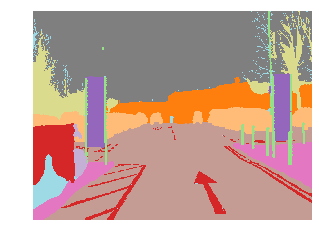

In [8]:
mask = open_mask(def_y_fn(img_sample))
mask.show(figsize=(5,5), alpha=1)

In [9]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([720, 960]), tensor([[[21, 21, 21,  ..., 21, 30, 30],
          [21, 21, 21,  ..., 21, 21, 30],
          [21, 21, 21,  ..., 21, 21, 30],
          ...,
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17]]]))

In [0]:
codes = np.loadtxt(path/'codes.txt', dtype=str)

In [0]:
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [11]:
len(codes), src_size

(32, array([720, 960]))

In [12]:
size = src_size//2; size

array([360, 480])

In [14]:
free_mem = gpu_mem_get_free_no_cache()
free_mem

11430

In [0]:
if free_mem > 8200: bs=8
else: bs=4

In [0]:
src = (SegmentationItemList.from_folder(path/'images')
      .split_by_fname_file(path/'valid.txt')
      .label_from_func(def_y_fn, classes=codes))

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
       .databunch(bs=bs)
       .normalize(imagenet_stats))

In [0]:
mask.shape

torch.Size([1, 720, 960])

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
name2id

In [0]:
void_code = name2id['Void']

In [0]:
def acc_camvid(input_, target):
  target = target.squeeze(1)
  mask = target != void_code
  return (input_.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics = acc_camvid
wd = 1e-2

In [0]:
learn = unet_learner(data, models.resnet34,
                     metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


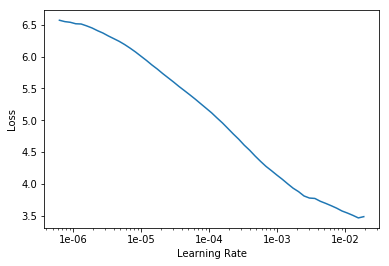

In [26]:
learn.lr_find()
learn.recorder.plot()

In [27]:
learn.fit_one_cycle(5, 1e-5)

epoch,train_loss,valid_loss,acc_camvid,time
0,4.671337,3.580253,0.090433,03:38
1,2.795217,1.688079,0.601421,03:37
2,1.735503,1.214192,0.745667,03:37
3,1.356015,1.092363,0.771542,03:37
4,1.220448,1.073103,0.778989,03:38


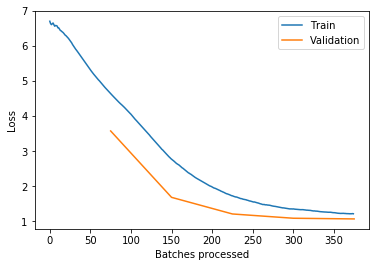

In [28]:
learn.recorder.plot_losses()

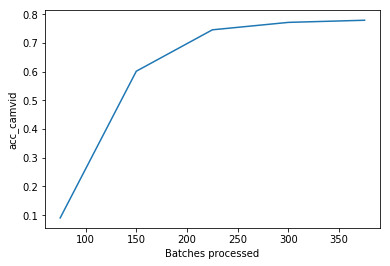

In [29]:
learn.recorder.plot_metrics()

In [0]:
learn.save('stage-1-small')
# learn.load('stage-1-small');

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


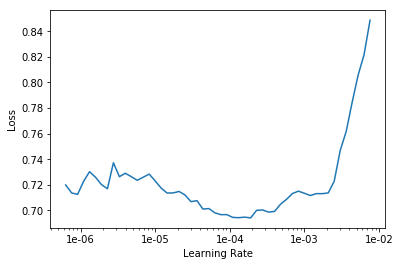

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(12, slice(3e-5, 3e-3/5))

epoch,train_loss,valid_loss,acc_camvid,time
0,0.695102,0.632825,0.835152,01:24
1,0.659330,0.585891,0.849834,01:26
2,0.613964,0.551678,0.857716,01:28
3,0.562548,0.489706,0.874727,01:28
4,0.511592,0.418106,0.879143,01:28
5,0.469041,0.436111,0.869811,01:28
6,0.424752,0.343919,0.902572,01:28
7,0.387980,0.320228,0.906614,01:28
8,0.369663,0.309430,0.911943,01:28
9,0.346548,0.301110,0.914502,01:28


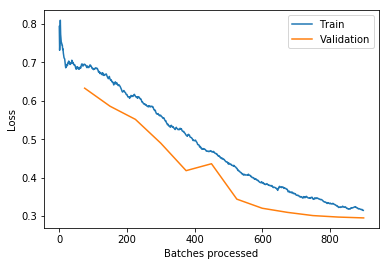

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.save('stage-2-small')

In [0]:
learn.destroy()

size = src_size
# size = np.array([720, 960])

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

this Learner object self-destroyed - it still exists, but no longer usable
using bs=3, have 13167MB of GPU RAM free


In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats)).to_fp16()

AttributeError: ignored

In [0]:
learn = unet_learner(data, models.resnet34,
                     metrics=metrics, wd=wd)

In [0]:
learn.load('stage-2-small');

In [0]:
learn.export('/drive/My Drive/ML DL Data/export.pkl')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


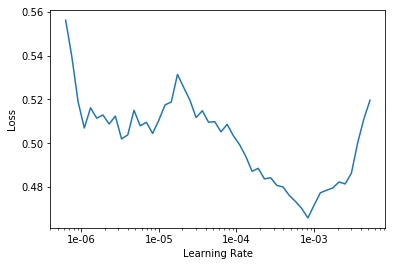

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, slice(1e-4))

epoch,train_loss,valid_loss,acc_camvid,time
0,0.455184,0.378398,0.894168,05:58
1,0.393506,0.374265,0.898007,05:53
2,0.377921,0.331228,0.905536,05:53
3,0.353658,0.319844,0.909706,05:53


KeyboardInterrupt: ignored

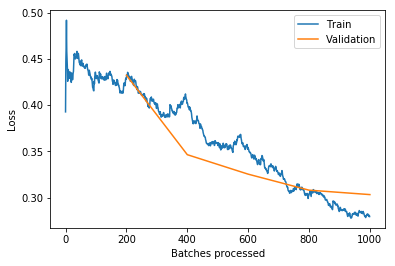

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.save('stage-1-big')

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


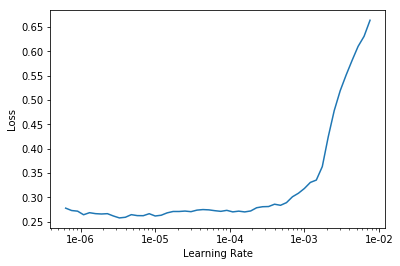

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(8, slice(1e-6, 3e-4/5))